In [15]:
import os
import platform
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
tf.get_logger().setLevel(logging.ERROR)

def _df(data):
    df = pd.DataFrame(data)
    for c in range(df.shape[1]):
        mapping = {df.columns[c]: c}
        df = df.rename(columns=mapping)
    return df

In [22]:
def load_and_preprocess():
    #Reading the pre_processed data
    os_type = platform.system()
    if os_type.startswith("Darwin"):
        data = pd.read_excel(r"dataset/processed_data/main/final_cleaned_dataset.xlsx")
    else: 
        data = pd.read_excel(r"dataset\processed_data\main\final_cleaned_dataset.xlsx")
    #Droping the target col
    feature_value_temp = data.drop("Laboratory confirmed, since the beginning of the pandemic Hospitalized", axis=1)
    #Droping the Distric col as it is string and will be assigned value by clustering
    features = feature_value_temp.drop("District",axis=1)
    features = features.drop("Unnamed: 0",axis=1)
    features = features.drop("Laboratory confirmed, since the beginning of the pandemic TOTAL",axis=1)
    features = features.drop("Laboratory confirmed, since the beginning of the pandemic RecoveredA",axis=1)
    features = features.drop("Laboratory confirmed, since the beginning of the pandemic Deceased",axis=1)


    data['flag'] = 3  # Initialize the 'flag' column with 3
    data.loc[data['Laboratory confirmed, since the beginning of the pandemic Hospitalized'] <= 449, 'flag'] = 2
    data.loc[data['Laboratory confirmed, since the beginning of the pandemic Hospitalized'] <= 290, 'flag'] = 1

    target_col = data["flag"]
    
    return features, np.array(target_col)

In [23]:
class Gan():

    def __init__(self, data):


        self.data = data
        self.n_epochs = 200

    # Genereta random noise in a latent space
    def _noise(self):
        noise = np.random.normal(0, 1, self.data.shape)
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(15, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(30, activation='relu'))
        model.add(tf.keras.layers.Dense(
            self.data.shape[1], activation='linear'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(25, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='relu'))
        # sigmoid => real or fake
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    # define the combined generator and discriminator model,
    # for updating the generator
    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    # train the generator and discriminator
    def train(self, generator, discriminator, gan):

        # determine half the size of one batch, for updating the  discriminator
        # manually enumerate epochs
        for epoch in range(self.n_epochs):
            
            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))


            print('>%d, d1=%.3f, d2=%.3f' %(epoch+1, d_loss, g_loss))

        return generator

In [24]:
features, target_col = load_and_preprocess()

model = Gan(data=features)
generator = model._generator()
descriminator = model._discriminator()
gan_model = model._GAN(generator=generator, discriminator=descriminator)
trained_model = model.train(generator=generator, discriminator=descriminator, gan=gan_model)

522/522 [==============================] - 0s 383us/step
>1, d1=438.635, d2=0.961
522/522 [==============================] - 0s 355us/step
>2, d1=371.784, d2=0.928
522/522 [==============================] - 0s 361us/step
>3, d1=304.918, d2=0.901
522/522 [==============================] - 0s 373us/step
>4, d1=238.151, d2=0.873
522/522 [==============================] - 0s 355us/step
>5, d1=171.614, d2=0.846
522/522 [==============================] - 0s 356us/step
>6, d1=111.733, d2=0.819
522/522 [==============================] - 0s 346us/step
>7, d1=72.165, d2=0.801
522/522 [==============================] - 0s 363us/step
>8, d1=46.103, d2=0.778
522/522 [==============================] - 0s 349us/step
>9, d1=28.211, d2=0.759
522/522 [==============================] - 0s 357us/step
>10, d1=16.134, d2=0.743
522/522 [==============================] - 0s 355us/step
>11, d1=8.208, d2=0.725
522/522 [==============================] - 0s 365us/step
>12, d1=3.659, d2=0.709
522/522 [============

522/522 [==============================] - 0s 352us/step
>102, d1=0.345, d2=0.804
522/522 [==============================] - 0s 381us/step
>103, d1=0.344, d2=0.817
522/522 [==============================] - 0s 360us/step
>104, d1=0.342, d2=0.827
522/522 [==============================] - 0s 356us/step
>105, d1=0.343, d2=0.838
522/522 [==============================] - 0s 339us/step
>106, d1=0.344, d2=0.847
522/522 [==============================] - 0s 350us/step
>107, d1=0.345, d2=0.849
522/522 [==============================] - 0s 358us/step
>108, d1=0.346, d2=0.850
522/522 [==============================] - 0s 351us/step
>109, d1=0.345, d2=0.847
522/522 [==============================] - 0s 351us/step
>110, d1=0.345, d2=0.842
522/522 [==============================] - 0s 348us/step
>111, d1=0.344, d2=0.837
522/522 [==============================] - 0s 359us/step
>112, d1=0.345, d2=0.833
522/522 [==============================] - 0s 353us/step
>113, d1=0.344, d2=0.830
522/522 [=======

In [29]:
noise = np.random.normal(0, 1, features.shape) 
new_data = _df(data=trained_model.predict(noise))

522/522 [==============================] - 0s 368us/step


Text(0.5, 1.0, 'synthetic Data')

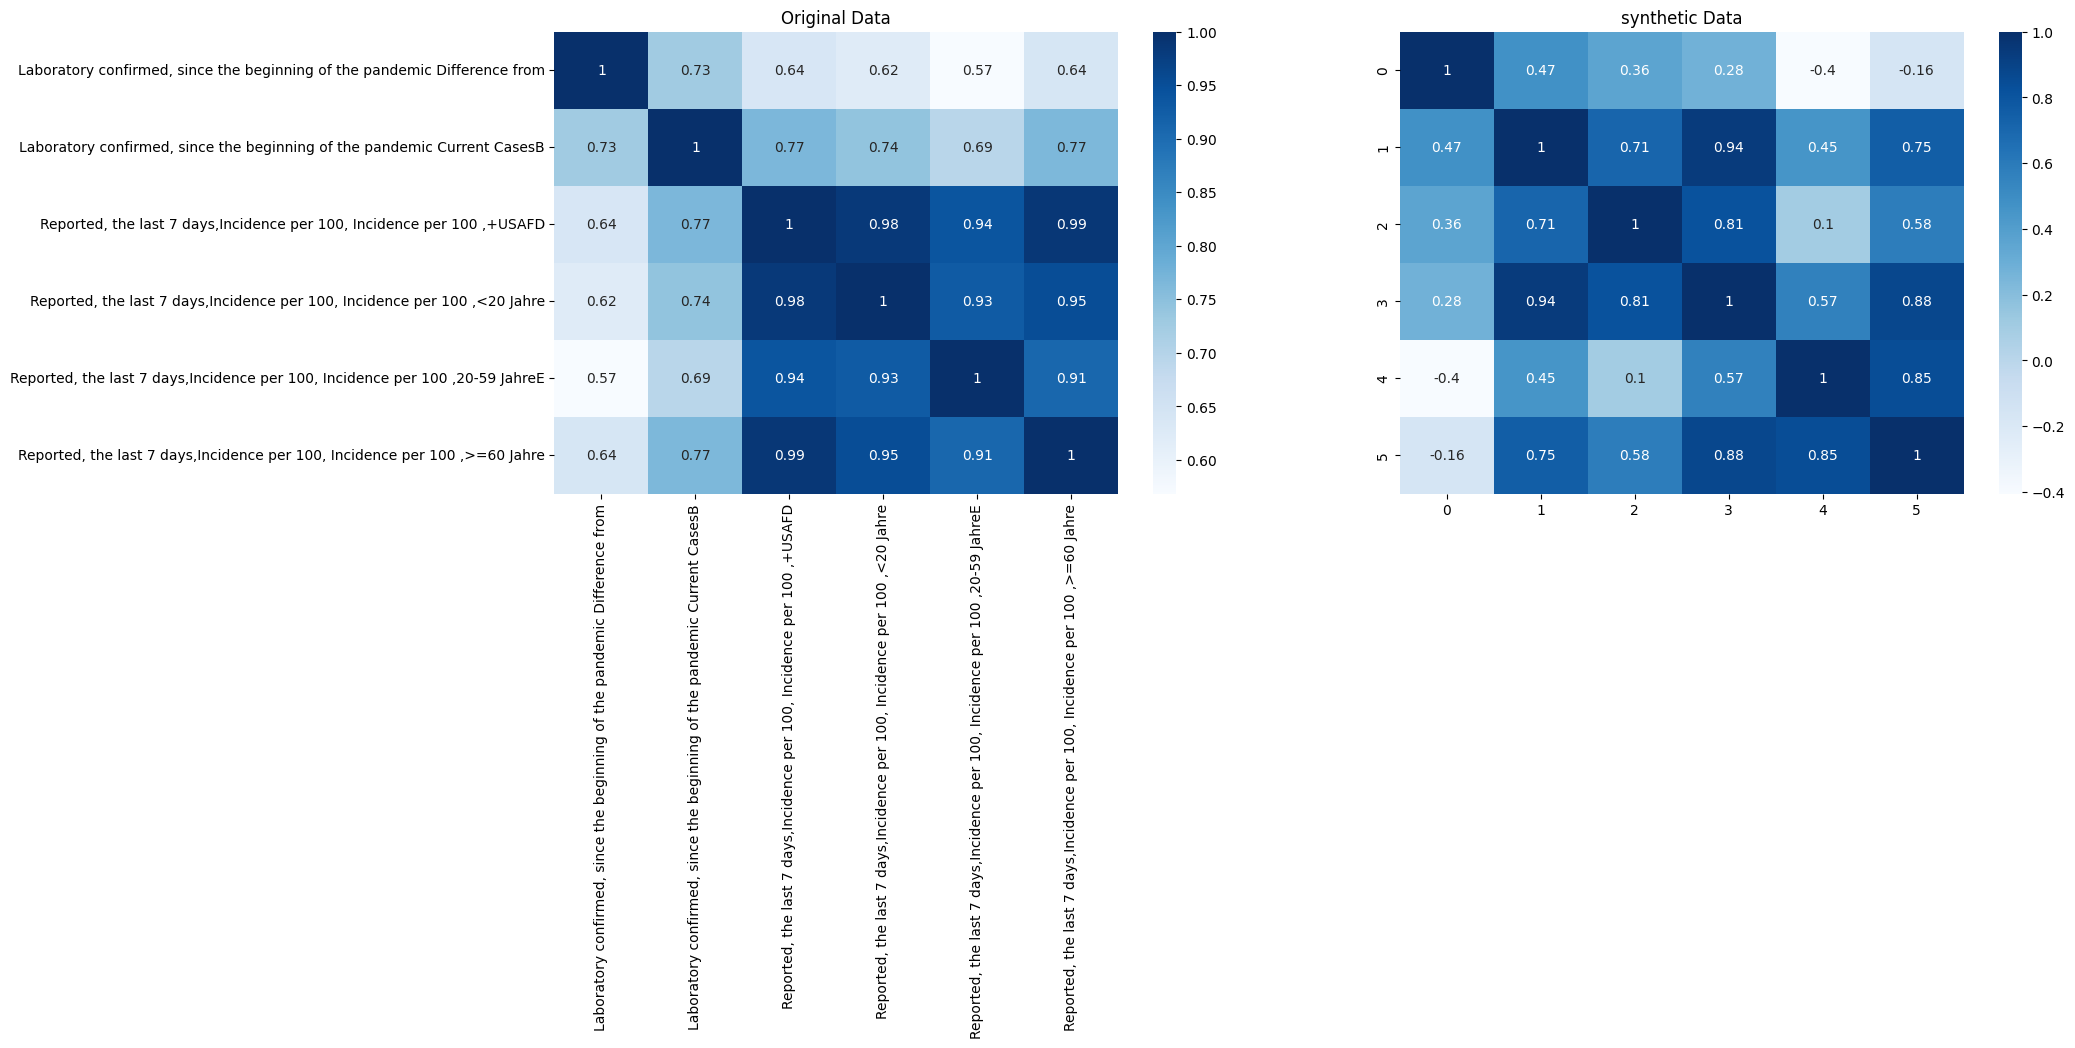

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(features.corr(), annot=True, ax=ax[0], cmap="Blues")
sns.heatmap(new_data.corr(), annot=True, ax=ax[1], cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

Text(0.5, 1.0, 'synthetic Data')

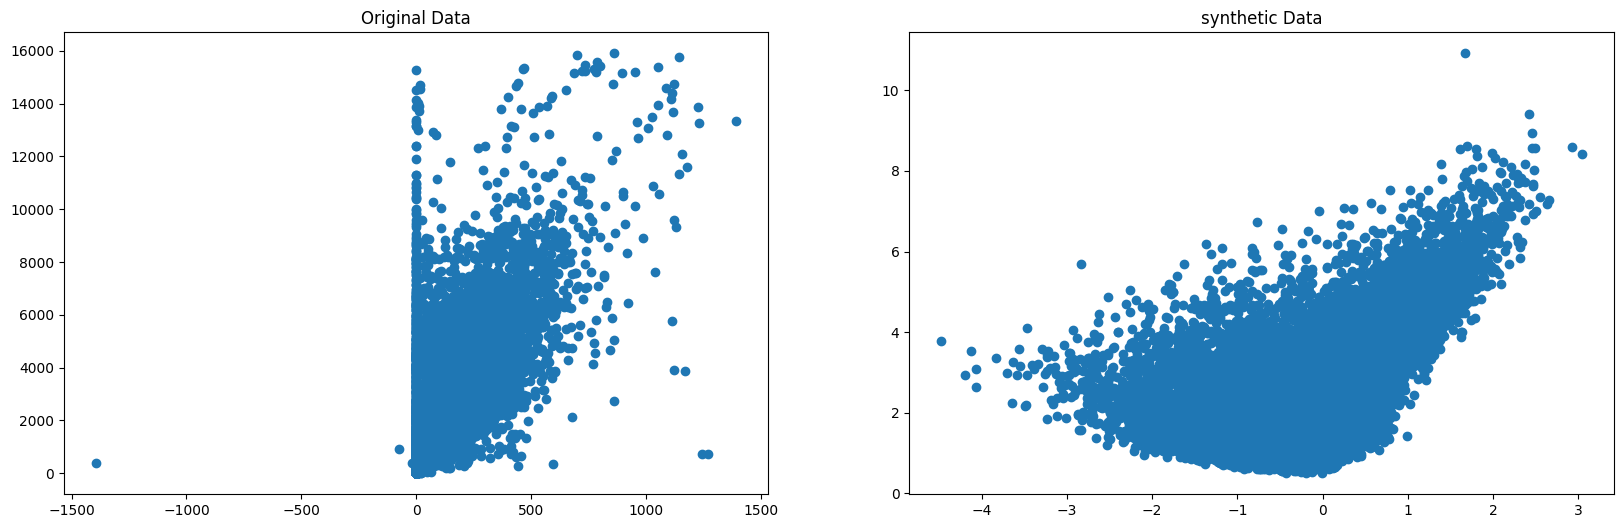

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(features.iloc[:, 0], features.iloc[:, 1])
ax[1].scatter(new_data.iloc[:, 0], new_data.iloc[:, 1])
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

In [37]:
np.save('GAN_generated_data.npy', new_data)